This notebook serves as the Deep Bayesian Active Learning paper implementation based on:
- https://github.com/damienlancry/DBAL/blob/master/dbal_pytorch.ipynb
- https://github.com/wohlert/semi-supervised-pytorch/blob/master/examples/notebooks/Deep%20Generative%20Model.ipynb

In [67]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Set number of initial labelled data per class
INITIAL_LABEL_PER_CLASS = 10
N_LABELS = 10 #MNIST

In [88]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner
from torchsummary import summary
import pickle

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import sys

In [69]:
# Use cuda if available
cuda = torch.cuda.is_available()
# Add a semi supervised module
sys.path.insert(0, './semi-supervised')

### Network Architecture

In [70]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.convs = nn.Sequential(
                        nn.Conv2d(1, 32, 4),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, 4),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Dropout(0.25),
                        nn.Flatten(),
                        nn.Linear(11*11*32, 128),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(128, 10)
                    )

    def forward(self, x):
        out = x
        out = self.convs(out)
        return out

In [71]:
summary(CNN().convs, (1,28,28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             544
              ReLU-2           [-1, 32, 25, 25]               0
            Conv2d-3           [-1, 32, 22, 22]          16,416
              ReLU-4           [-1, 32, 22, 22]               0
         MaxPool2d-5           [-1, 32, 11, 11]               0
           Dropout-6           [-1, 32, 11, 11]               0
           Flatten-7                 [-1, 3872]               0
            Linear-8                  [-1, 128]         495,744
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 513,994
Trainable params: 513,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [72]:
train = MNIST('.', train=True, download=True, transform=ToTensor())
test = MNIST('.', train=False, download=True, transform=ToTensor())
train_data_loader = DataLoader(train, shuffle = True, batch_size = 60_000)
test_data_loader = DataLoader(test, shuffle = True, batch_size = 10_000)
X_train, y_train = next(iter(train_data_loader))
X_train = X_train.detach().cpu().numpy()
y_train = y_train.detach().cpu().numpy()

X_test, y_test = next(iter(test_data_loader))
X_test = X_test.detach().cpu().numpy()
y_test = y_test.detach().cpu().numpy()


## Preprocessing

In [73]:
X_train = X_train.reshape(60_000, 1, 28, 28)
X_test = X_test.reshape(10_000, 1, 28, 28)

In [74]:
# Create initial labelled data
# Take INITIAL_LABELLED_PER_CLASS samples from each digit
initial_labelled_idx = np.array([],dtype=np.int64)
for i in range(N_LABELS):
    idx = np.random.choice(np.where(y_train==i)[0], size=INITIAL_LABEL_PER_CLASS, replace=False)
    initial_labelled_idx = np.concatenate((initial_labelled_idx, idx))

X_train_labelled_initial = X_train[initial_labelled_idx]
y_train_labelled_initial = y_train[initial_labelled_idx]

In [75]:
# Create a pool of unlabelled data
X_train_unlabelled = np.delete(X_train, initial_labelled_idx, axis = 0)
y_train_unlabelled = np.delete(y_train, initial_labelled_idx, axis = 0)

### Query Strategies

#### Random (Uniform)

In [76]:
def uniform(learner, X, n_instances = 1):
    query_idx = np.random.choice(range(len(X)), size = n_instances, replace = False)
    return query_idx, X[query_idx]

#### Max Entropy

Formula:

$$\mathbb{H} = -\sum_{c}p_clog(p_c)$$

Where $p_c$ is the probability of the instance being in the class $c$ and is approximated by:

$$p_c = \dfrac{1}{T}\sum_{c}p_c^{(t)}$$

Where $p_c^{(t)}$ is the probability of the instance being in the class $c$ at t-th forward pass

In [77]:
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    acquisition = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

#### Bald

In [78]:
def bald(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]    


### Active Learning 

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"

query_strategies = {'random':{'function':uniform,
                                'classifier': None,
                                'learner': None,
                                'performance_history': None},
                    # 'max_entropy':{'function':max_entropy,
                    #             'classifier': None,
                    #             'learner': None,
                    #             'performance_history': None},
                    'bald':{'function':bald,
                                'classifier': None,
                                'learner': None,
                                'performance_history': None},
                    }

In [80]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10,
                              query_strategy_label=''):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('{q}Accuracy after query {n}: {acc:0.4f}'.format(q=f'[{query_strategy_label}] ', n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)

    # Save after-query labelled and unlabelled data
    torch.save(learner.X_training, f'./saved_data/X_train_labelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
    torch.save(learner.y_training, f'./saved_data/y_train_labelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')

    torch.save(X_pool, f'./saved_data/X_train_unlabelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
    torch.save(y_pool, f'./saved_data/y_train_unlabelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')

    return learner, perf_hist

In [81]:
for query_strategy_name, query_strategy in query_strategies.items():
    query_strategy['classifier'] = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
    query_strategy['learner'], query_strategy['performance_history'] = active_learning_procedure(query_strategy['function'],
                                                X_test,
                                                y_test,
                                                X_train_unlabelled,
                                                y_train_unlabelled,
                                                X_train_labelled_initial,
                                                y_train_labelled_initial,
                                                query_strategy['classifier'],
                                                query_strategy_label=query_strategy_name)

[random] Accuracy after query 1: 0.7993
[random] Accuracy after query 2: 0.7904
[random] Accuracy after query 3: 0.8072
[random] Accuracy after query 4: 0.8354
[random] Accuracy after query 5: 0.8282
[random] Accuracy after query 6: 0.8450
[random] Accuracy after query 7: 0.8777
[random] Accuracy after query 8: 0.8686
[random] Accuracy after query 9: 0.8779
[random] Accuracy after query 10: 0.8811
[random] Accuracy after query 11: 0.8808
[random] Accuracy after query 12: 0.8942
[random] Accuracy after query 13: 0.8901
[random] Accuracy after query 14: 0.8771
[random] Accuracy after query 15: 0.8902
[random] Accuracy after query 16: 0.8895
[random] Accuracy after query 17: 0.8979
[random] Accuracy after query 18: 0.9007
[random] Accuracy after query 19: 0.8975
[random] Accuracy after query 20: 0.9030
[random] Accuracy after query 21: 0.9199
[random] Accuracy after query 22: 0.9124
[random] Accuracy after query 23: 0.9142
[random] Accuracy after query 24: 0.9188
[random] Accuracy after q

In [82]:
# Save models and data
performance_histories = {}
for query_strategy_name, query_strategy in query_strategies.items():
    # Save classifiers
    query_strategy['classifier'].save_params(f_params=f'./saved_models/{query_strategy_name}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pkl')

    # Save data after queries:
    # torch.save(query_strategy['learner'].X_training, f'./saved_data/X_training_{query_strategy_name}.pt')
    # torch.save(query_strategy['learner'].y_training, f'./saved_data/y_training_{query_strategy_name}.pt')

# Save initial labelled and unlabelled data
X_train_labelled_initial = X_train[initial_labelled_idx]
y_train_labelled_initial = y_train[initial_labelled_idx]
torch.save(X_train_labelled_initial, f'./saved_data/X_train_labelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
torch.save(y_train_labelled_initial, f'./saved_data/y_train_labelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
torch.save(X_train_unlabelled, f'./saved_data/X_train_unlabelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
torch.save(y_train_unlabelled, f'./saved_data/y_train_unlabelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')

# Save test data
torch.save(X_test, f'./saved_data/X_test.pt')
torch.save(y_test, f'./saved_data/y_test.pt')

# Save performance histories (preprocessing)
performance_histories = {query_strategy_name: query_strategy['performance_history'] for query_strategy_name, query_strategy in query_strategies.items()}
pd.DataFrame(performance_histories).to_csv(f'./saved_data/active_learning_performance_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}.csv')


In [97]:
x_ticks = [i*100 for i in range(11)]

In [98]:
x_ticks

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [103]:
query_strategies['bald']['performance_history']

[0.7712,
 0.8166,
 0.8005,
 0.8069,
 0.81,
 0.8314,
 0.8528,
 0.8612,
 0.865,
 0.8918,
 0.8779,
 0.8947,
 0.8924,
 0.9073,
 0.9155,
 0.9246,
 0.9281,
 0.9163,
 0.9127,
 0.9299,
 0.9293,
 0.9315,
 0.9487,
 0.9451,
 0.9437,
 0.9486,
 0.9472,
 0.9408,
 0.9491,
 0.948,
 0.9522,
 0.9556,
 0.9582,
 0.9545,
 0.9587,
 0.9522,
 0.9584,
 0.9568,
 0.9597,
 0.9658,
 0.9631,
 0.9635,
 0.9611,
 0.9679,
 0.9676,
 0.9677,
 0.9648,
 0.9723,
 0.9692,
 0.9705,
 0.9678,
 0.9744,
 0.9695,
 0.9726,
 0.9716,
 0.9766,
 0.975,
 0.973,
 0.975,
 0.9743,
 0.9727,
 0.9757,
 0.9741,
 0.9762,
 0.9745,
 0.9785,
 0.9749,
 0.9733,
 0.9742,
 0.9741,
 0.9755,
 0.9742,
 0.9809,
 0.978,
 0.9761,
 0.9761,
 0.9783,
 0.9797,
 0.9817,
 0.9801,
 0.9778,
 0.9789,
 0.9784,
 0.9765,
 0.9802,
 0.9801,
 0.9816,
 0.9819,
 0.9784,
 0.9791,
 0.9799,
 0.9787,
 0.9816,
 0.9822,
 0.9817,
 0.981,
 0.9811,
 0.9848,
 0.9831,
 0.9836,
 0.9823]

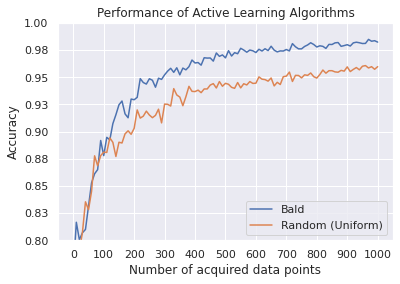

In [120]:
# Plot
sns.set()
# plt.plot(query_strategies['max_entropy']['performance_history'], label="max entropy")
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001, 100)
ax.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001, 10)
ax.plot(x_ticks, query_strategies['bald']['performance_history'], label="Bald")
ax.plot(x_ticks, query_strategies['random']['performance_history'], label="Random (Uniform)")
ax.set_ylim([0.8,1])

ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of acquired data points")
ax.set_title("Performance of Active Learning Algorithms")
ax.legend()


###  Semi-supervised Learning

<img src="./images/dgm.png" width="400px"/>

In [122]:
from models import DeepGenerativeModel

x_dim = 784
y_dim = 10
z_dim = 32
h_dim = [256, 128]

model = DeepGenerativeModel([x_dim, y_dim, z_dim, h_dim])
# model


In [123]:
from datautils import get_mnist

# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
labelled, unlabelled, test = get_mnist(location="./saved_data", batch_size=64, labels_per_class=INITIAL_LABEL_PER_CLASS, algorithm='bald')
alpha = 0.1 * len(unlabelled) / len(labelled)

def binary_cross_entropy(y_pred, y):
    return -torch.sum(y * torch.log(y_pred + 1e-8) + (1 - y) * torch.log(1 - y_pred + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))


./saved_data/X_train_labelled_bald_100.pt
./saved_data/y_train_labelled_bald_100.pt
1100 1100
./saved_data/X_train_unlabelled_bald_100.pt
./saved_data/y_train_unlabelled_bald_100.pt
58900 58900
./saved_data/X_test.pt
./saved_data/y_test.pt
10000 10000


In [117]:
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler

# You can use importance weighted samples [Burda, 2015] to get a better estimate
# on the log-likelihood.
sampler = ImportanceWeightedSampler(mc=1, iw=1)

if cuda: model = model.cuda()
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)


In [132]:
def calculate_J_alpha(x, y, u, alpha, model):
    x, y, u = Variable(x).cuda(device=0), Variable(y).cuda(device=0), Variable(u).cuda(device=0)

    L = -elbo(x, y)
    U = -elbo(u)

    # Add auxiliary classification loss q(y|x)
    logits = model.classify(x)
    
    # Regular cross entropy
    classification_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

    J_alpha = L + alpha * classification_loss + U

    return J_alpha

In [11]:
from torch.autograd import Variable

for epoch in range(100):
    model.train()
    total_loss, accuracy = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = Variable(x), Variable(y), Variable(u)

        if cuda:
            # They need to be on the same device and be synchronized.
            x, y = x.cuda(device=0), y.cuda(device=0)
            u = u.cuda(device=0)

        L = -elbo(x, y)
        U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        logits = model.classify(x)
        
        # Regular cross entropy
        classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L + alpha * classication_loss + U

        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.data
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        
    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in test:
            x, y = Variable(x), Variable(y)

            if cuda:
                x, y = x.cuda(device=0), y.cuda(device=0)

            L = -elbo(x, y)
            U = -elbo(x)

            logits = model.classify(x)
            classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classication_loss + U

            total_loss += J_alpha.data

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(test)
        print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))


Epoch: 0
[Train]		 J_a: 400.76, accuracy: 0.82
[Validation]	 J_a: 318.45, accuracy: 0.83
Epoch: 1
[Train]		 J_a: 321.91, accuracy: 0.97
[Validation]	 J_a: 293.73, accuracy: 0.88
Epoch: 2
[Train]		 J_a: 304.59, accuracy: 0.99
[Validation]	 J_a: 282.21, accuracy: 0.90
Epoch: 3
[Train]		 J_a: 293.93, accuracy: 1.00
[Validation]	 J_a: 275.59, accuracy: 0.91
Epoch: 4
[Train]		 J_a: 287.56, accuracy: 1.00
[Validation]	 J_a: 270.48, accuracy: 0.92
Epoch: 5
[Train]		 J_a: 283.18, accuracy: 1.00
[Validation]	 J_a: 266.64, accuracy: 0.93
Epoch: 6
[Train]		 J_a: 279.42, accuracy: 1.00
[Validation]	 J_a: 263.19, accuracy: 0.93
Epoch: 7
[Train]		 J_a: 276.60, accuracy: 1.00
[Validation]	 J_a: 261.85, accuracy: 0.94
Epoch: 8
[Train]		 J_a: 273.27, accuracy: 1.00
[Validation]	 J_a: 259.64, accuracy: 0.94
Epoch: 9
[Train]		 J_a: 271.91, accuracy: 1.00
[Validation]	 J_a: 257.73, accuracy: 0.94
Epoch: 10
[Train]		 J_a: 269.85, accuracy: 1.00
[Validation]	 J_a: 257.04, accuracy: 0.95
Epoch: 11
[Train]		 